In [1]:
import tensorflow as tf
import numpy as np
import cv2 as cv
import glob
import matplotlib.pylab as plt

from model.model import FeatureTransfer, Encoder, Decoder

plt.rcParams["figure.autolayout"] = True
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

2023-01-03 16:19:30.388300: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
basic_encoder = Encoder()
basic_encoder.load_weights('encoder-basic_font.h5')

target_decoder = Decoder()
target_decoder.load_weights('decoder-target_font.h5')

transfer = FeatureTransfer()
transfer.load_weights('transfer.h5')


2023-01-03 16:19:46.078096: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
basic_images = []
target_images = []
for path in glob.glob('datasets/validation/*.png'):
    image = tf.keras.utils.load_img(path)
    image = tf.keras.preprocessing.image.img_to_array(image)
    basic_image = image[:, :80, :] # the original font
    target_image = image[:, 80:, :] # the target font
    
    basic_image = tf.image.rgb_to_grayscale(basic_image)
    basic_images.append(basic_image)
    target_image = tf.image.rgb_to_grayscale(target_image)
    target_images.append(target_image)
    
basic_images = np.array(basic_images)
target_images = np.array(target_images)
basic_images.shape

(402, 80, 80, 1)

In [4]:
indices = [i for i in range(0, basic_images.shape[0])]
random_indices = np.random.choice(indices, size=3*3)
random_basic_images = basic_images[random_indices, :]
random_basic_images = random_basic_images/255
random_basic_images.shape

random_target_images = target_images[random_indices, :]

In [5]:
basic_pretidcted = basic_encoder.predict(random_basic_images)
print(f'源字体特征编码：{basic_pretidcted.shape}')

1/1 [==============================] - 1s 863ms/step
源字体特征编码：(9, 10, 10, 256)


In [6]:
transfer_pretidcted = transfer.predict(basic_pretidcted)
print(f'源字体特征迁移：{transfer_pretidcted.shape}')

1/1 [==============================] - 0s 470ms/step
源字体特征迁移：(9, 10, 10, 256)


In [7]:
decoder_pretidcted = target_decoder.predict(transfer_pretidcted)
decoder_pretidcted.shape
print(f'目标字体特征解码：{decoder_pretidcted.shape}')

1/1 [==============================] - 2s 2s/step
目标字体特征解码：(9, 80, 80, 1)


<Figure size 6000x3000 with 0 Axes>

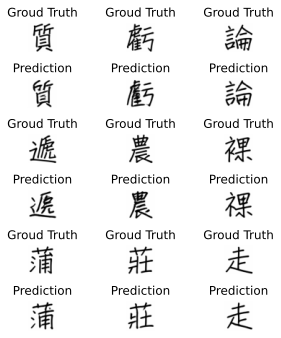

In [8]:

rows = 3*2
columns = 3
plt.figure(figsize=(20, 10), dpi=300)
fig, ax = plt.subplots(rows, columns)
for row in range(rows):
    for column in range(columns):
        if row%2 == 0: # Groud Truth
            image = random_target_images[row//2*columns+column]
            ax[row,column].set_title('Groud Truth')
        else: 
            predicted_image = decoder_pretidcted[row//2*columns+column]
            image = predicted_image*255.0
            ax[row,column].set_title('Prediction')
        image = image.astype(np.uint8)
        ax[row,column].imshow(image, cmap='gray', vmin=0, vmax=255)
        ax[row,column].axis('off')